# Dependency distribution in UD languages

Dependency relations are expected to have different distributions between languages. This purpose of this notebook is to give you a quick overlook of their distribution. 

Possibly critical decisions: 

- I ignore everything after the colon in the deprel label. That is, _nsubj:something_ counts as _nsubj_.
- I count relations between words, not between tokens. E.g, _haven't_ is separated as _have not_, with its new relation counted.

In [3]:
%matplotlib inline
import matplotlib
from matplotlib import pylab
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
matplotlib.style.use('ggplot')

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('../tools/')
import udtree, lang_utils

import pandas as pd
import seaborn as sns

from os import listdir
from os.path import join
from collections import defaultdict

from scipy.stats import entropy

file_format = "conllu"
train_type = "train"
gold_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-2/universal-dependencies-1.2/"
file_prefix = "dependency_distribution"
treebanks = lang_utils.get_ud_paths(gold_output_base, type_=train_type, format_=file_format, coarse=False)

# Languages ordered according to their sTTR score (see other notebook for how).
sttr_order = pd.DataFrame.from_csv('../data/standard_ttr.1.2.csv').index

            
def sum_deprels(trees):
    deprels = defaultdict(int)
    for tree in trees:
        for deprel in tree.deprels:
            # Ignoring language specific labels
            deprels[deprel.split(":")[0]] += 1
    return deprels
        
df_dict = {}
for language, treebank in treebanks.items():
    deprels = sum_deprels(udtree.from_files(treebank))
    df_dict[language] = deprels

deprel_per_lang = pd.DataFrame.from_dict(df_dict).transpose()

## Dependency distribution: Sorted by most common

Leftmost on the x-axis is the most commonly occurring relation (as in the sum of their ratio in each language) among all languages.

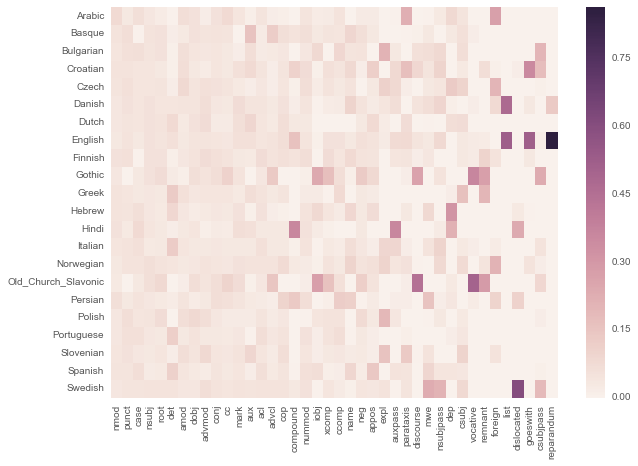

In [4]:
normalized = deprel_per_lang.div(deprel_per_lang.sum(axis=1), axis=0).fillna(0)
most_common_rels = normalized.sum(axis=0).sort_values(ascending=False)
normalized = normalized.div(normalized.sum(axis=0), axis=1)
sns.heatmap(normalized[most_common_rels.index])

# Sort languages by sTTR and relations by entropy

We will use the results in [Type-token ratio in Universal Dependencies treebanks](/notebooks/Type-token%20ratio%20in%20Universal%20Dependencies%20treebanks.ipynb) to sort the languages in an order that makes it easier to find discriminative dependency relations.

We also calculate the entropy of a dependency relation to find out its discriminative power. The lower the entropy, the stronger its discriminative power is. We sort the deprels according to this.

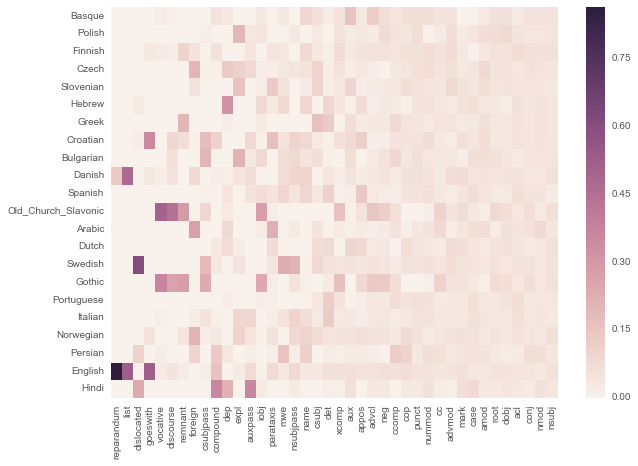

In [5]:
dep_entropies = pd.Series(entropy(normalized), normalized.columns).sort_values()
dep_entropies.to_csv('../data/crosslingual_dependency_entropy.csv')
entropy_sorted = normalized[dep_entropies.index].ix[sttr_order].fillna(0)
entropy_normalized = entropy_sorted.div(entropy_sorted.sum(axis=0), axis=1)
sns.heatmap(entropy_normalized)

# Conclusion

First and foremost, we can say that the following are more or less equally distributed across all classes: conj, punct, cc, nmod, nsubj, dobj, root, nummod, amod, advmod, acl, cop, mark, case, neg, advcl.

I would like to say that we start to see some differences for these classes: ccomp, det, appos, aux, csubj, name, xcomp, parataxis, mwe, nsubjpass, ccompound, auxpass, vocative, iobj, csubjpass, discourse, expl, remnant, foreign, dep, list, goeswith, dislocated, reparandum (only present in Danish and English), subj (only present in Hebrew). 

It is not exactly clear that this will help us create the content and functional dependency classification. I will have to think about this a bit more.

# Followup: Dependency distribution within each language

How are dependency relations distributed within the languages themselves, and not across all languages as seen previously?

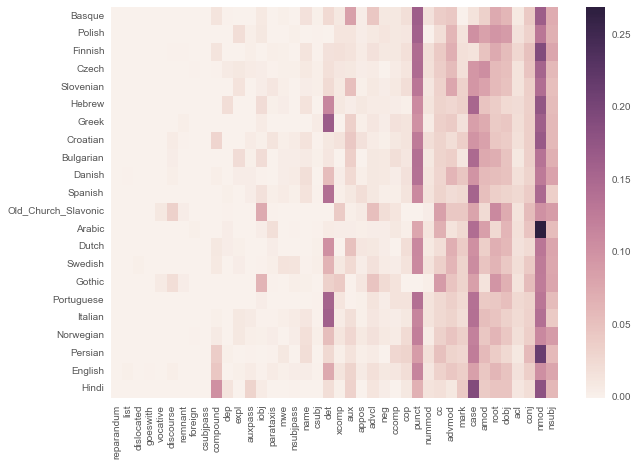

In [6]:
normalized = deprel_per_lang.div(deprel_per_lang.sum(axis=1), axis=0).fillna(0)
sns.heatmap(normalized[dep_entropies.index].ix[sttr_order])

We see that nmod and punct are highly common for all languages. _case_ seem to be common for more isolated languages, as is det. 

_nmod_ is strong for Hebrew, Persian, and Finnish. 